# 04 GMM

In [ ]:
# Setup
!pip install -q numpy pandas matplotlib seaborn scikit-learn umap-learn mlxtend

### 2.4 Gaussian Mixture Models (GMM)

I **Gaussian Mixture Models** rappresentano i dati come una miscela di distribuzioni gaussiane. A differenza di K-Means, GMM fornisce una **probabilita di appartenenza** a ciascun cluster (soft clustering).

#### Matematica di GMM

La probabilita di un punto $x$ e:

$$p(x) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x | \mu_k, \Sigma_k)$$

dove:
- $\pi_k$ = peso della componente $k$ (somma a 1)
- $\mu_k$ = media della gaussiana $k$
- $\Sigma_k$ = matrice di covarianza della gaussiana $k$

L'algoritmo **Expectation-Maximization (EM)** ottimizza iterativamente i parametri.

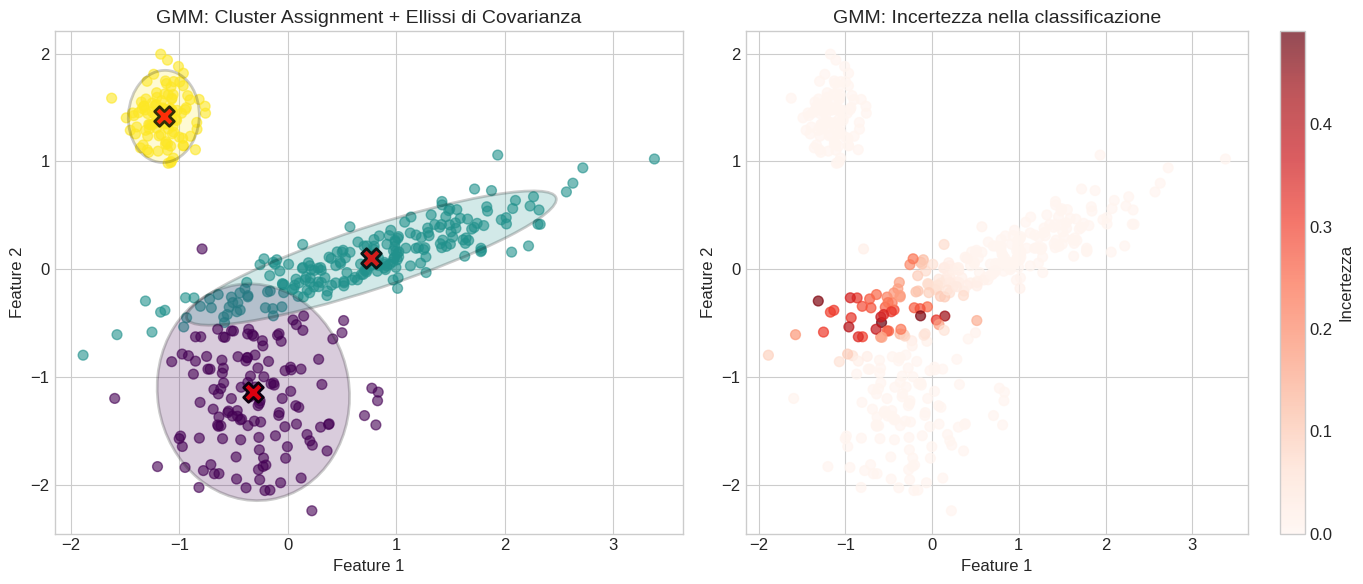

SELEZIONE NUMERO DI COMPONENTI
Numero ottimale di componenti (BIC): 3
Numero ottimale di componenti (AIC): 3


In [7]:
# SEZIONE 2.4: Gaussian Mixture Models
# Questa sezione e completamente incapsulata

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse

# Generazione dati con cluster di dimensioni diverse
np.random.seed(42)
n1, n2, n3 = 100, 200, 150

# Cluster 1: piccolo e compatto
cluster1 = np.random.randn(n1, 2) * 0.5 + np.array([-3, 3])
# Cluster 2: allungato
cluster2 = np.random.randn(n2, 2) @ np.array([[2, 0.5], [0.5, 0.5]]) + np.array([2, 0])
# Cluster 3: grande
cluster3 = np.random.randn(n3, 2) * 1.2 + np.array([-1, -3])

X_gmm = np.vstack([cluster1, cluster2, cluster3])
scaler_gmm = StandardScaler()
X_gmm_scaled = scaler_gmm.fit_transform(X_gmm)

# Fit GMM
gmm = GaussianMixture(
    n_components=3,
    covariance_type='full',  # Matrice di covarianza completa
    random_state=42,
    n_init=5
)
labels_gmm = gmm.fit_predict(X_gmm_scaled)
probs_gmm = gmm.predict_proba(X_gmm_scaled)

# Funzione per disegnare ellissi di confidenza
def draw_ellipse(position, covariance, ax, **kwargs):
    """Disegna ellisse di confidenza per una gaussiana"""
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s) * 2  # 2 deviazioni standard
    else:
        angle = 0
        width = height = 2 * np.sqrt(covariance) * 2

    ellipse = Ellipse(position, width, height, angle=angle, **kwargs)
    ax.add_patch(ellipse)

# Visualizzazione
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Hard assignment
scatter1 = axes[0].scatter(X_gmm_scaled[:, 0], X_gmm_scaled[:, 1],
                           c=labels_gmm, cmap='viridis', alpha=0.6, s=50)
axes[0].scatter(gmm.means_[:, 0], gmm.means_[:, 1],
                c='red', marker='X', s=200, edgecolors='black', linewidths=2)

# Disegna ellissi
for i, (mean, cov) in enumerate(zip(gmm.means_, gmm.covariances_)):
    draw_ellipse(mean, cov, axes[0], alpha=0.2,
                 facecolor=plt.cm.viridis(i / (gmm.n_components - 1)), edgecolor='black', linewidth=2)

axes[0].set_title('GMM: Cluster Assignment + Ellissi di Covarianza', fontsize=14)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Probabilita di appartenenza (incertezza)
uncertainty = 1 - probs_gmm.max(axis=1)  # Maggiore = piu incerto
scatter2 = axes[1].scatter(X_gmm_scaled[:, 0], X_gmm_scaled[:, 1],
                           c=uncertainty, cmap='Reds', alpha=0.7, s=50)
plt.colorbar(scatter2, ax=axes[1], label='Incertezza')
axes[1].set_title('GMM: Incertezza nella classificazione', fontsize=14)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

# Selezione del numero di componenti con BIC/AIC
print("=" * 50)
print("SELEZIONE NUMERO DI COMPONENTI")
print("=" * 50)

n_components_range = range(1, 8)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm_temp = GaussianMixture(n_components=n, random_state=42)
    gmm_temp.fit(X_gmm_scaled)
    bic_scores.append(gmm_temp.bic(X_gmm_scaled))
    aic_scores.append(gmm_temp.aic(X_gmm_scaled))

print(f"Numero ottimale di componenti (BIC): {np.argmin(bic_scores) + 1}")
print(f"Numero ottimale di componenti (AIC): {np.argmin(aic_scores) + 1}")

**Osservazioni importanti su GMM**

- Fornisce probabilita di appartenenza (utile quando i cluster si sovrappongono)
- Puo modellare cluster ellittici con `covariance_type='full'`
- Usare BIC o AIC per selezionare il numero di componenti
- Piu flessibile di K-Means ma piu costoso computazionalmente

**Quando usare GMM**

- Cluster di forma ellittica
- Quando serve la probabilita di appartenenza
- Cluster sovrapposti
- Come modello generativo

### Riepilogo: Confronto algoritmi di clustering

| Algoritmo | Richiede K | Forma cluster | Outlier | Complessita | Uso tipico |
|-----------|------------|---------------|---------|-------------|------------|
| **K-Means** | Si | Sferici | No | O(n*k*i) | Segmentazione clienti |
| **DBSCAN** | No | Arbitraria | Si | O(n log n) | Dati spaziali |
| **Hierarchical** | Opzionale | Varia | No | O(n³) | Biologia, tassonomie |
| **GMM** | Si | Ellittici | No | O(n*k*i) | Soft clustering |